**Requisitos**

tensorflow==1.13.1

keras==2.2.4

h5py==2.10.0

keras-contrib by: pip install git+https://www.github.com/keras-team/keras-contrib.git

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git # Needed for using CRF
!pip install seqeval

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-n_w7yrm9
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-n_w7yrm9
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101077 sha256=7056eeeca26aff68a816abb71599a6c72b85f5329170394dbd3f11f5b7faff65
  Stored in directory: /tmp/pip-ephem-wheel-cache-dghi07ef/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib
     |████████████████████████████████| 43 kB 1.0 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=9e7578a5fbe19032c775af05c93d471e2fa27f2e7b87208fe5e02166bd026c1f
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import he_normal
from keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model, Input, model_from_json, load_model
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_accuracy, crf_viterbi_accuracy
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Carregar dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_filepath = '/content/drive/MyDrive/UFAM/TCC/seq_tag_lstm_crf_v2/Treinamento/Dataset/dataset_annotated_v3.txt'
data = "./Coleta de sentencas/text_"

def get_sentences(file):
    with open(file,'r') as f:
        sentences = f.read().split("\n\n")
        return sentences
    
def extract_words_tags(sentence):
    wt = []
    
    pair = sentence.split("\n")
    for p in pair:
        if p.startswith(" "):
            continue
        splitted = p.split(" ")
        wt.append((splitted[0],splitted[1]))
    return wt

sentences = get_sentences(data_filepath)
print('{} sentenças encontradas!'.format(len(sentences)))

wt_sentences = [extract_words_tags(s) for s in sentences]

2517 sentenças encontradas!


**Explorar o tamanho das sentenças**

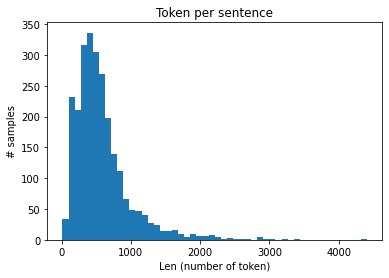

In [ ]:
import matplotlib.pyplot as plt
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

**Vocabulários de palavras e tags**

In [ ]:
words = list(set([wt[0] for s in wt_sentences for wt in s]))
words.append("ENDPAD")
n_words = len(words)
print('Quantidade de palavras encontradas: {}'.format(n_words))

tags = list(set([wt[1] for s in wt_sentences for wt in s]))
# tags = ['B-LEGISLACAO','I-LEGISLACAO','O']
n_tags = len(tags)
print('Tags: {}'.format(tags))
print('Length: {}'.format(n_tags))

word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

Quantidade de palavras encontradas: 13581
Tags: ['I-LEGISLACAO', 'O', 'B-LEGISLACAO']
Length: 3


# Preparando sentenças

In [ ]:
max_len = 500

X = [[word2idx[w[0]] for w in s] for s in wt_sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)

y = [[tag2idx[w[1]] for w in s] for s in wt_sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
y = [to_categorical(i, num_classes=n_tags) for i in y]

**Separação dos dados de treinamento e teste**

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)

# Treinar o modelo

In [ ]:
def create_model(maxlen, n_words):
  input = Input(shape=(maxlen,))
  model = Embedding(input_dim=n_words+1, output_dim=500, input_length=maxlen)(input)
  model = Bidirectional(LSTM(units=50, 
                           return_sequences=True, 
                           dropout=0.5,
                           recurrent_dropout=0.5,
                           kernel_initializer=he_normal()))(model)
  model = TimeDistributed(Dense(50, activation="relu"))(model)  
  crf = CRF(n_tags)
  out = crf(model)
  model = Model(input, out)

  opt = RMSprop(lr=0.05)
  model.compile(optimizer=opt, loss=crf.loss_function, metrics=[crf.accuracy], )
  model.summary()

  return model

In [ ]:
model = create_model(max_len, n_words)

In [ ]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5, validation_split=0.2, verbose=1)

In [ ]:
hist = pd.DataFrame(history.history)

plt.style.use("ggplot")
plt.figure(figsize=(12, 12))
plt.plot(hist["crf_viterbi_accuracy"])
plt.plot(hist["val_crf_viterbi_accuracy"])
plt.show()

# Avaliar

In [ ]:
test_pred = model.predict(X_te, verbose=1)
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out

pred_labels = pred2label(test_pred)
test_labels = pred2label(y_te)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
print(classification_report(test_labels, pred_labels))

**Predictions**

In [ ]:
i = 18
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))

# Salvar modelo

In [ ]:
model_filename = "/content/drive/MyDrive/UFAM/TCC/seq_tag_lstm_crf_v2/Models/model_v4"

model.save(model_filename+".h5")

# serializar para JSON
model_json = model.to_json()
with open(model_filename+".json", "w") as json_file:
    json_file.write(model_json)
    
# serializar para HDF5
model.save_weights(model_filename+"_weights.h5")

In [ ]:
import pickle
with open("/content/drive/MyDrive/UFAM/TCC/seq_tag_lstm_crf_v2/Models/word2idx_v4_13581","wb") as word2idx_file:
    pickle.dump(word2idx, word2idx_file)